# [Cross Validating Prophet at Scale](https://medium.com/dropout-analytics/cross-validating-prophet-at-scale-72b1a21b6433?source=friends_link&sk=e7b1201491dd528dfa3ad3b9a324518c)
## Distributed Time Series Cross Validation with Dask

<AxesSubplot:title={'center':'Average Trip Distance (Miles) - NYC Yellow Cab'}, xlabel='ds'>

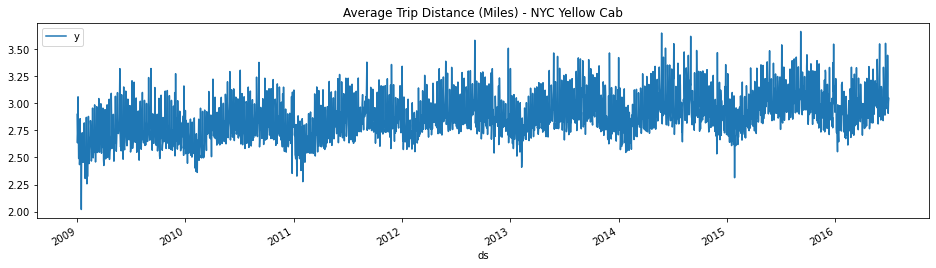

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/gumdropsteve/datasets/master/yellow_cab_ymd_averages.csv', usecols=['ds', 'avg_trip_distance'])

df['ds'] = pd.to_datetime(df['ds'])
df['avg_trip_distance'] = df['avg_trip_distance'].astype('float')

# remove erroneous averages
df = df.loc[df['avg_trip_distance'] < 5]

# relabel average trip distance as y
df = df.rename(columns={'avg_trip_distance' : 'y'})

df.plot(x='ds', y='y', figsize=(16, 4), title='Average Trip Distance (Miles) - NYC Yellow Cab', )

In [2]:
from fbprophet import Prophet

m = Prophet(daily_seasonality=False)

m.add_country_holidays(country_name='US')

m.fit(df)

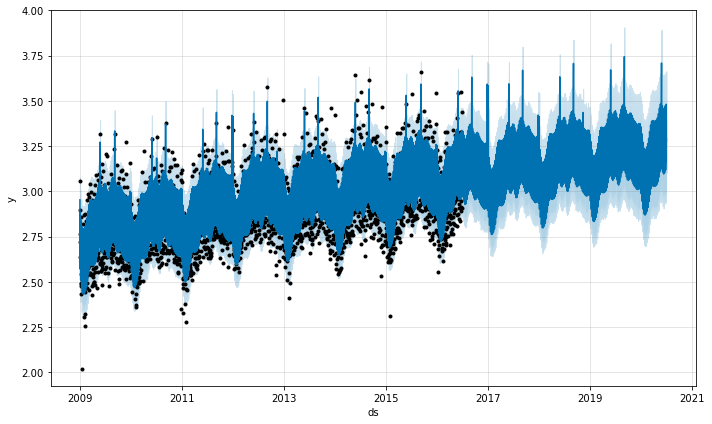

In [3]:
future = m.make_future_dataframe(periods=365*4)

forecast = m.predict(future)

fig = m.plot(forecast)

In [4]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-01,2.695823,2.826591,3.076750,2.695823,2.695823,0.0,0.0,0.0,0.0,...,-0.038124,-0.038124,-0.038124,-0.057114,-0.057114,-0.057114,0.0,0.0,0.0,2.953523
1,2009-01-02,2.695925,2.476915,2.719023,2.695925,2.695925,0.0,0.0,0.0,0.0,...,-0.036389,-0.036389,-0.036389,-0.063069,-0.063069,-0.063069,0.0,0.0,0.0,2.596467
2,2009-01-03,2.696026,2.458230,2.697680,2.696026,2.696026,0.0,0.0,0.0,0.0,...,-0.055264,-0.055264,-0.055264,-0.069305,-0.069305,-0.069305,0.0,0.0,0.0,2.571457
3,2009-01-04,2.696127,2.763837,3.010922,2.696127,2.696127,0.0,0.0,0.0,0.0,...,0.262290,0.262290,0.262290,-0.075766,-0.075766,-0.075766,0.0,0.0,0.0,2.882651
4,2009-01-05,2.696229,2.544944,2.792523,2.696229,2.696229,0.0,0.0,0.0,0.0,...,0.054307,0.054307,0.054307,-0.082393,-0.082393,-0.082393,0.0,0.0,0.0,2.668143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,2020-06-25,3.150770,2.987312,3.366324,3.020043,3.273610,0.0,0.0,0.0,0.0,...,-0.038124,-0.038124,-0.038124,0.066945,0.066945,0.066945,0.0,0.0,0.0,3.179591
4183,2020-06-26,3.150868,3.007083,3.351086,3.020030,3.273835,0.0,0.0,0.0,0.0,...,-0.036389,-0.036389,-0.036389,0.067841,0.067841,0.067841,0.0,0.0,0.0,3.182320
4184,2020-06-27,3.150966,2.986414,3.337065,3.019950,3.274060,0.0,0.0,0.0,0.0,...,-0.055264,-0.055264,-0.055264,0.068360,0.068360,0.068360,0.0,0.0,0.0,3.164062
4185,2020-06-28,3.151065,3.297123,3.663906,3.019864,3.274284,0.0,0.0,0.0,0.0,...,0.262290,0.262290,0.262290,0.068470,0.068470,0.068470,0.0,0.0,0.0,3.481825


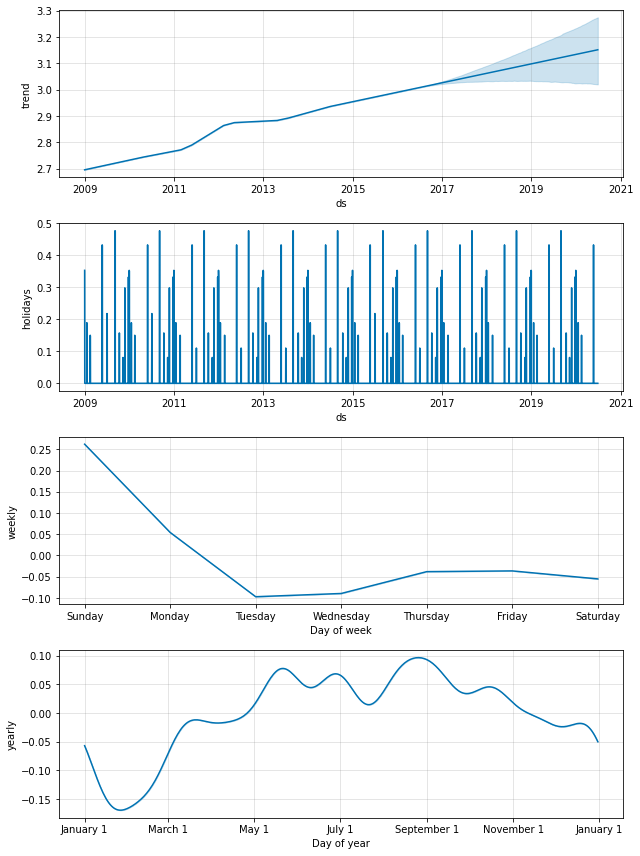

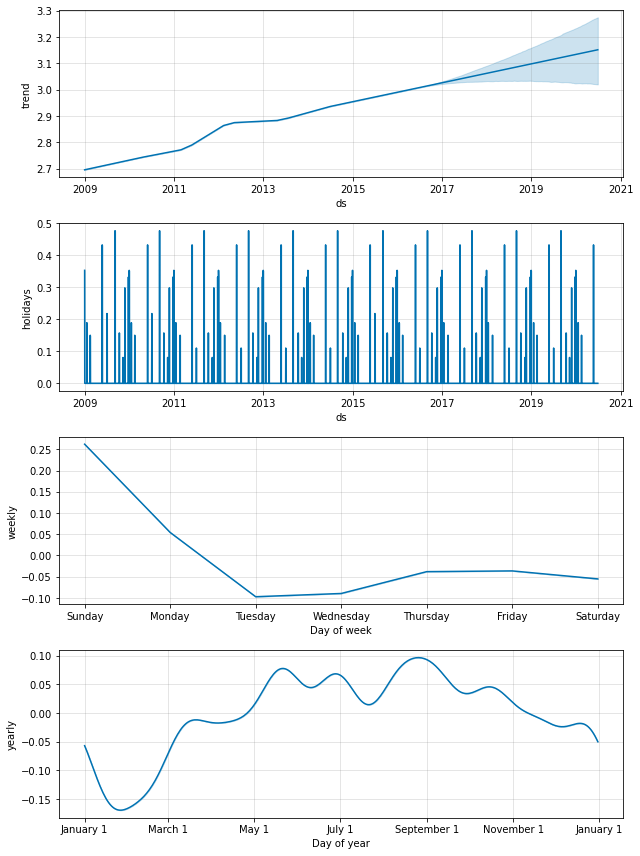

In [5]:
m.plot_components(forecast)

In [6]:
from distributed import Client
from fbprophet.diagnostics import cross_validation

client = Client()
client

C:\Users\war23\Anaconda3\envs\prophet\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49475 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:49478 Dashboard: http://127.0.0.1:49475/status,Cluster Workers: 4 Cores: 8 Memory: 8.42 GB


In [7]:
%%time
df_cv = cross_validation(m, 
                         horizon="365 days",
                         period="182.5 days", 
                         initial="730 days", 
                         parallel="dask"
                        )

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


Wall time: 23.3 s


In [8]:
%%time
df_cv = cross_validation(m, 
                         horizon="365 days",
                         period="182.5 days", 
                         initial="730 days", 
                         parallel=None
                        )

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00



Wall time: 32 s


In [9]:
from fbprophet.diagnostics import performance_metrics

performance_metrics(df_cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,365 days,0.013147,0.114661,0.088697,0.03037,0.024807,0.714067


In [10]:
%%time
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
              'seasonality_mode': ['additive', 'multiplicative']}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for i in range(len(all_params)):
    print(f'cross validating param set {i} / {len(all_params) - 1}')
    
    # create & fit model with given params combo
    m = Prophet(daily_seasonality=False, **all_params[i]).fit(df)
    
    # cross validate the model 
    df_cv = cross_validation(m, 
                             horizon="365 days",
                             period="182.5 days", 
                             initial="730 days", 
                             parallel="dask")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    # pull rmse and add it to the list
    rmses.append(df_p['rmse'].values[0])

cross validating param set 0 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 1 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 2 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 3 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 4 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 5 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 6 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 7 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 8 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 9 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 10 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 11 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 12 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 13 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 14 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 15 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 16 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 17 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 18 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 19 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 20 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 21 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 22 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 23 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 24 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 25 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 26 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 27 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 28 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 29 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 30 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


cross validating param set 31 / 31


INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-07-02 00:00:00 and 2015-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49478' processes=4 threads=8, memory=8.42 GB>


Wall time: 10min 57s


In [11]:
# make a dataframe of all the param combos
tuning_results = pd.DataFrame(all_params)

# add a column for each's RMSE
tuning_results['rmse'] = rmses

tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
0,0.001,0.01,additive,0.116632
1,0.001,0.01,multiplicative,0.116066
2,0.001,0.10,additive,0.116868
3,0.001,0.10,multiplicative,0.115954
4,0.001,1.00,additive,0.116443
5,0.001,1.00,multiplicative,0.116610
6,0.001,10.00,additive,0.116285
7,0.001,10.00,multiplicative,0.116344
8,0.010,0.01,additive,0.118546
9,0.010,0.01,multiplicative,0.118514


In [12]:
import numpy as np

# pull the highest scoring param combo
best_params = all_params[np.argmin(rmses)]

best_params

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative'}

### Try the Best Model

In [13]:
m = Prophet(daily_seasonality=False, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, seasonality_mode='multiplicative')

m.add_country_holidays(country_name='US')

m.fit(df)

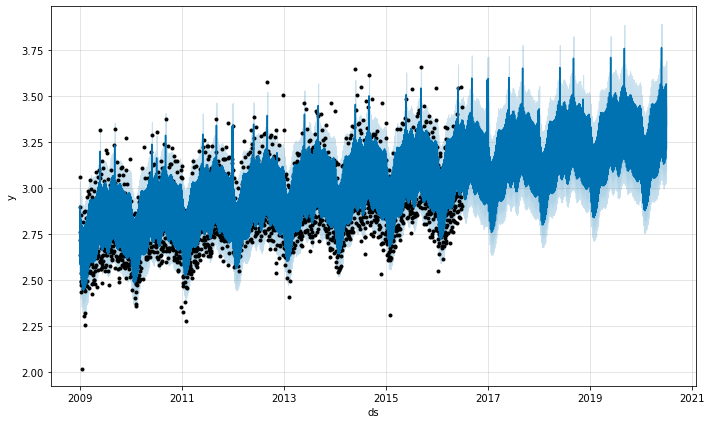

In [14]:
future = m.make_future_dataframe(periods=365*4)

forecast = m.predict(future)

fig = m.plot(forecast)

In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2009-01-01,2.697347,2.789544,3.037441,2.697347,2.697347,0.0,0.0,0.0,0.0,...,-0.013268,-0.013268,-0.013268,-0.016551,-0.016551,-0.016551,0.0,0.0,0.0,2.903270
1,2009-01-02,2.697466,2.488562,2.738520,2.697466,2.697466,0.0,0.0,0.0,0.0,...,-0.012460,-0.012460,-0.012460,-0.018783,-0.018783,-0.018783,0.0,0.0,0.0,2.613190
2,2009-01-03,2.697585,2.464420,2.708225,2.697585,2.697585,0.0,0.0,0.0,0.0,...,-0.020089,-0.020089,-0.020089,-0.021150,-0.021150,-0.021150,0.0,0.0,0.0,2.586341
3,2009-01-04,2.697704,2.751315,2.995276,2.697704,2.697704,0.0,0.0,0.0,0.0,...,0.091168,0.091168,0.091168,-0.023629,-0.023629,-0.023629,0.0,0.0,0.0,2.879904
4,2009-01-05,2.697824,2.559541,2.807865,2.697824,2.697824,0.0,0.0,0.0,0.0,...,0.020700,0.020700,0.020700,-0.026195,-0.026195,-0.026195,0.0,0.0,0.0,2.682999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,2020-06-25,3.196385,3.113396,3.352659,3.196359,3.196412,0.0,0.0,0.0,0.0,...,-0.013268,-0.013268,-0.013268,0.023508,0.023508,0.023508,0.0,0.0,0.0,3.229114
4183,2020-06-26,3.196504,3.110505,3.352611,3.196478,3.196531,0.0,0.0,0.0,0.0,...,-0.012460,-0.012460,-0.012460,0.023965,0.023965,0.023965,0.0,0.0,0.0,3.233281
4184,2020-06-27,3.196623,3.093972,3.333088,3.196597,3.196650,0.0,0.0,0.0,0.0,...,-0.020089,-0.020089,-0.020089,0.024281,0.024281,0.024281,0.0,0.0,0.0,3.210024
4185,2020-06-28,3.196742,3.445765,3.691670,3.196716,3.196769,0.0,0.0,0.0,0.0,...,0.091168,0.091168,0.091168,0.024441,0.024441,0.024441,0.0,0.0,0.0,3.566314
